<a href="https://colab.research.google.com/github/tomervazana/Clustering-Political-Posts/blob/main/kmeans_umap_clustering_political_posts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal is to cluster political messages from the dataset: [Political Social Media Posts](https://www.kaggle.com/datasets/crowdflower/political-social-media-posts)
To achieve this goal were using k-means clustering with the elbow / knee method and visualize the results using UMAP

In [ ]:
!pip install scikit-learn

In [ ]:
!pip3 install sentence-transformers

  Using cached sentence_transformers-3.0.1-py3-none-any.whl (227 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans
import pandas as pd #a
from sentence_transformers import SentenceTransformer
import re
import os
#from Deep_Learning.Translation.translation import translate
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#import hdbscan
from scipy.spatial.distance import cosine
from collections import Counter
from sklearn.preprocessing import normalize
from datetime import datetime
import pandas as pd #a
from sentence_transformers import SentenceTransformer
import re
import os
#from Deep_Learning.Translation.translation import translate
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#import hdbscan
from scipy.spatial.distance import cosine
from collections import Counter
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, dbscan, AgglomerativeClustering
import random

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
def process_text(text):
    if (type(text) != str):
        text = ''
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    text = re.sub(r"([A-Za-z]+)'s", r"\1 is", text)
    text = re.sub(r"won't", "will not ", text)
    text = re.sub(r"isn't", "is not ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()

    return text

In [ ]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
corpus = pd.read_csv('/content/political_social_media.csv', encoding='latin-1')['text']

In [ ]:
corpus

0       RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1       VIDEO - #Obamacare:  Full of Higher Costs and ...
2       Please join me today in remembering our fallen...
3       RT @SenatorLeahy: 1st step toward Senate debat...
4       .@amazon delivery #drones show need to update ...
                              ...                        
4995    I applaud Governor PerryÛªs recent decision t...
4996    Today, I voted in favor of H.R. 5016 - Financi...
4997    (Taken from posted WOKV interview)   Congressm...
4998    Join me next week for a town hall in Ocala! I'...
4999    Foreign Affairs Committee Hearing on Syria. I ...
Name: text, Length: 5000, dtype: object

In [ ]:
corpus = [process_text(t) for t in corpus]
temp = []
for txt in corpus:
  new_sentence = ''
  for char in txt:
    if char in '0123456789 QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm':
      if len(new_sentence) > 0 and new_sentence[-1] == ' ' and char == ' ':
        # to deny extra spaces
        continue
      new_sentence += char
  temp.append(new_sentence)
corpus = temp
#corpus = list(set(corpus))
print(len(corpus))

5000


# Embed the texts

In [ ]:
start = datetime.now()
corpus_split = [word for sent in corpus for word in sent.split()]
corpus_embeddings = []
jmp = 500
for i in range(500, len(corpus), jmp):
  x = i - 500
  corpus_embeddings.append(model.encode(corpus[x:i]))
  print(i)
corpus_embeddings.append(model.encode(corpus[x+jmp:len(corpus)]))
end = datetime.now()
print(end-start)

print(len(corpus_embeddings))
tmp = corpus_embeddings
embed = []
for i in range(len(corpus_embeddings)):
  for j in range(len(corpus_embeddings[i])):
    embed.append(tmp[i][j])

corpus = [process_text(t) for t in corpus]
# corpus_set = set(corpus)
# corpus = list(corpus_set)

print(len(corpus))


print(len(np.unique(corpus)))
print(len(embed))


500
1000
1500
2000
2500
3000
3500
4000
4500
0:00:05.594510
10
5000
4982
5000


In [ ]:
from sklearn.preprocessing import StandardScaler

X = embed
scaler = StandardScaler()
embed = scaler.fit_transform(X)

In [ ]:
print(len(embed))

5000


# Locate the knee / elbow

In [ ]:
!pip install kneed

In [ ]:
wcss=[]
for i in range(1,40):
  kmeans = KMeans(i, n_init='auto')
  kmeans.fit(embed)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)
  if i % 10 == 0:
    print(i)

10
20
30


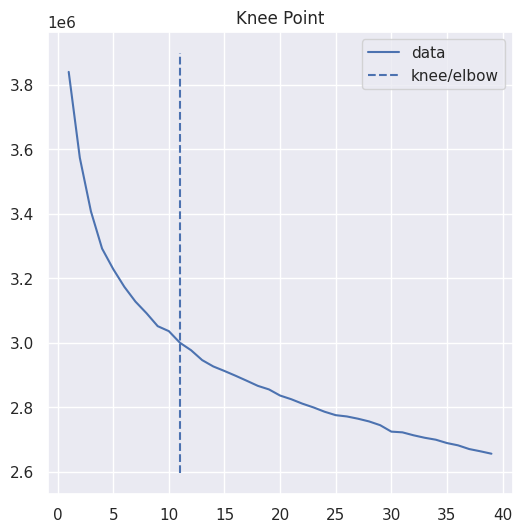

In [ ]:
from kneed import KneeLocator


kl = KneeLocator(range(1, 40), wcss, curve="convex", direction="decreasing")
kl.plot_knee()

In [ ]:
kl.knee

11

# Clustering using k-means

In [ ]:
k = kl.knee
kmeans = KMeans(k, n_init='auto')
kmeans.fit(embed)
cluster_assignment = kmeans.fit_predict(embed)
clustered_sentences = [[] for i in range(k)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
  try:
    clustered_sentences[cluster_id].append(corpus[sentence_id])
  except:
    print('-------ERROR-------')
    print('len(clustered_sentences)', len(clustered_sentences))
    print('cluster_id', cluster_id)
    print('len(seed_corpus)', len(corpus))
    print('sentence_id', sentence_id)
for i, cluster in enumerate(clustered_sentences):
  print("Cluster ", i + 1)
  print('len:', len(cluster))
  print()

Cluster  1
len: 116

Cluster  2
len: 381

Cluster  3
len: 572

Cluster  4
len: 548

Cluster  5
len: 491

Cluster  6
len: 532

Cluster  7
len: 446

Cluster  8
len: 515

Cluster  9
len: 319

Cluster  10
len: 587

Cluster  11
len: 493



In [ ]:
def find_representive_sentence(sentences, model):
  m = {}
  similarities = []
  for i in sentences:
    res = 0
    if i not in m:
      m[i] = model.encode([i])[0]
    cur = i
    for j in sentences:
      if j == i:
        continue
      if j not in m:
        m[j] = model.encode([j])[0]
      res += cosine(m[i], m[j])
    similarities.append(res)
  sorted_index_array = np.argsort(similarities)
  n_biggest = [sentences[sorted_index_array[i]] for i in range(-1, -4, -1)]
  n_smallest = [sentences[sorted_index_array[i]] for i in range(4)]
  return n_biggest, n_smallest

In [ ]:
for i, cluster in enumerate(clustered_sentences):
  print("Cluster ", i + 1)
  min_sent, max_sent = find_representive_sentence(cluster, model)
  print('min_sent', min_sent)
  print('max_sent', max_sent)

Cluster  1
min_sent ['botanical gardens', 'rt doddfrank three years later', 'mt sat guests']
max_sent ['sotu', 'well said', 'listen now', 'schmitty yes']
Cluster  2
min_sent ['the last abortion clinic in mississippi', 'delawareans including in african americans in new castle county has hiv gettested nhtd', 'i urge you to continue to pray for the people of west texas']
max_sent ['on monday we honored the millions of veterans who made the ultimate sacrifice for our nation our soldiers are given the best training and resources for the battlefield they deserve the best treatment and care when they return home recent revelations of veteran mistreatment and facility mismanagement are appalling and heads needed to roll secretary shinseki has led an honorable and distinguished career in service to our country but it is time for new leadership to tackle the longstanding problems facing the va to fix our broken va system and provide personalized veteran care there needs to be accountability at t

# Visualization using UMAP

In [ ]:
import numpy as np
from datetime import datetime
import sys

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 10.1 MB/s eta 0:00:00


In [ ]:
!pip install umap-learn[plot]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 79.1 MB/s eta 0:00:00


In [ ]:
from umap import UMAP
import umap.plot


umap_data = UMAP(n_neighbors=100, n_components=2, metric='euclidean', n_epochs=100, learning_rate=0.1, init='spectral',
                 min_dist=0.1, spread=1.0, low_memory=False, set_op_mix_ratio=1.0, local_connectivity=1,
                 repulsion_strength=1.0, negative_sample_rate=5, transform_queue_size=4.0, random_state=3,
                 angular_rp_forest=False, target_n_neighbors=-1, transform_seed=3, verbose=False, unique=False)

In [ ]:
label = pd.read_csv('/content/political_social_media.csv', encoding='latin-1')['message']

In [ ]:
label

0        policy
1        attack
2       support
3        policy
4        policy
         ...   
4995    support
4996     policy
4997     policy
4998      media
4999    support
Name: message, Length: 5000, dtype: object

In [ ]:
X = embed

After Kmeans

In [ ]:
X_train_umap = umap_data.fit_transform(X, cluster_assignment)

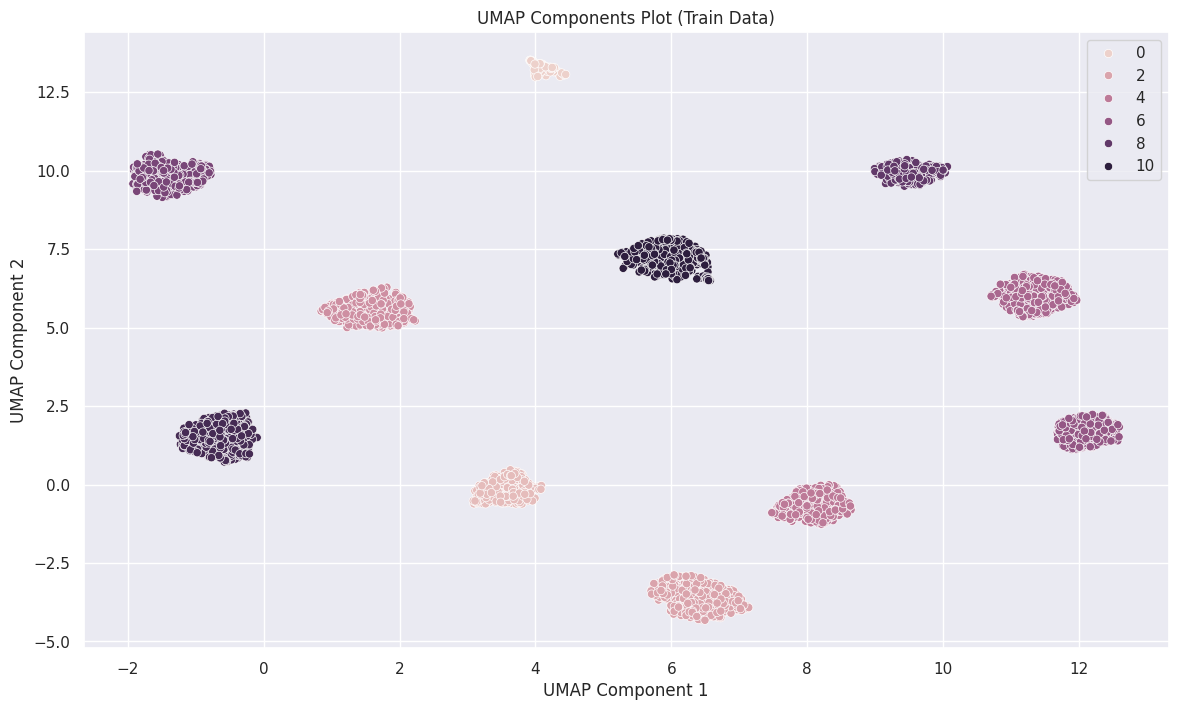

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


plt.figure(figsize=(14,8))
sns.scatterplot(x=X_train_umap[:,0], y=X_train_umap[:,1], hue=cluster_assignment)
plt.title('UMAP Components Plot (Train Data)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()